+ https://github.com/JuliaAcademy/DataScience/raw/master/10.%20Neural%20Nets.ipynb

In [3]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()
Pkg.resolve()

mkpath("downloads")
mkpath("out")

 Activating environment at `C:\Users\i am\Documents\GitHub\stage-Machine-learning\notebook\appunti\Project.toml`
   Updating registry at `C:\Users\i am\.julia\registries\General`
  Resolving package versions...
  Installed ZygoteRules ─────── v0.2.0
  Installed Functors ────────── v0.1.0
  Installed Media ───────────── v0.5.0
  Installed IRTools ─────────── v0.4.1
  Installed ChainRules ──────── v0.7.19
  Installed NNlib ───────────── v0.7.4
  Installed Flux ────────────── v0.11.1
  Installed CUDA ────────────── v1.3.3
  Installed MuladdMacro ─────── v0.2.2
  Installed VectorizationBase ─ v0.12.33
  Installed GPUArrays ───────── v5.2.0
  Installed LLVM ────────────── v2.0.0
  Installed SIMDPirates ─────── v0.8.25
  Installed SLEEFPirates ────── v0.5.5
  Installed ChainRulesCore ──── v0.9.10
  Installed Juno ────────────── v0.8.3
  Installed CpuId ───────────── v0.2.2
  Installed Zygote ──────────── v0.5.7
  Installed ArrayLayouts ────── v0.3.8
  Installed GPUCompiler ─────── v0.6.1
  I

"out"

In [4]:
using Flux, Flux.Data.MNIST
using Flux: onehotbatch, argmax, crossentropy, throttle
using Base.Iterators: repeated
using Images

┌ Info: Precompiling Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1278


Exception calling "DownloadFile" with "2" argument(s): "The operation has timed out."
At line:12 char:1
+ $webclient.DownloadFile("https://pkg.julialang.org/artifact/c68026379 ...
+ ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    + CategoryInfo          : NotSpecified: (:) [], MethodInvocationException
    + FullyQualifiedErrorId : WebException
 


In [5]:
# stack cuda: https://juliagpu.gitlab.io/CUDA.jl/
# per programmare su gpu nvidia
# gpu son ottimizz per calcolare matrici di float32
# prendiamo immagini e convertiamole in greyscale per tramutarle in matrici di float32
# facciamo ciò su dataset di immagini:
imgs = MNIST.images()
colorview(Gray, imgs[100])#tipo di un elemento prima delle conversionji
@show typeof(imgs[3])
# sono ghià in grigio, convertiamo in mat
myFloat32(X) = Float32.(X) #definiamo funzione per convertire campi matrice in float32 al volo
fpt_imgs = myFloat32.(imgs)#eseguiamola su ogni elemento del dataset di immagini
#otteniamo dataset di matrici di float32
@show typeof(fpt_imgs[3])#tipo di un elemento dopo conversione

┌ Info: Downloading MNIST dataset
└ @ Flux.Data.MNIST C:\Users\i am\.julia\packages\Flux\05b38\src\data\mnist.jl:24
┌ Info: Downloading MNIST dataset
└ @ Flux.Data.MNIST C:\Users\i am\.julia\packages\Flux\05b38\src\data\mnist.jl:24
┌ Info: Downloading MNIST dataset
└ @ Flux.Data.MNIST C:\Users\i am\.julia\packages\Flux\05b38\src\data\mnist.jl:24
┌ Info: Downloading MNIST dataset
└ @ Flux.Data.MNIST C:\Users\i am\.julia\packages\Flux\05b38\src\data\mnist.jl:24


typeof(imgs[3]) = Array{Gray{Normed{UInt8,8}},2}
typeof(fpt_imgs[3]) = Array{Float32,2}


Array{Float32,2}

In [7]:
#ora vettorizziamo le matrici:
@show typeof(fpt_imgs)#tipo del dataset prima della vettorizzaz
vectorize(x) = x[:]
vectorized_imgs = vectorize.(fpt_imgs);
@show typeof(vectorized_imgs)#tipo dataset con matrici vettorizzate

typeof(fpt_imgs) = Array{Array{Float32,2},1}
typeof(vectorized_imgs) = Array{Array{Float32,1},1}


Array{Array{Float32,1},1}

In [8]:
#come ultima manipolaz preliminare tramutiamo il dataset in una matrice unidimensionale dove ogni colonna è un immagine vettorizzata:
X = hcat(vectorized_imgs...)
size(X)

(784, 60000)

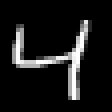

In [9]:
# abbiamo 60000 colonna = 60000 immagini
#per estrarre e eveder un immagine dobbiamo prendere una colonna e ritramutarla in una matrice di float->greyscale
onefigure = X[:,3]
t1 = reshape(onefigure,28,28)
colorview(Gray,t1)

In [10]:
#prendiamo le etichette
labels = MNIST.labels()
labels[1]

5

In [11]:
#spoiler: la rete, vedendo un immagine, ritornerà un vettore[10] dove vettore[i=1:10] = probabilità che l'immagine sia il numero i-1
#quindi prendiamo le label e tramutiamole in vettore[10] dove vettore[i=1:10] = i sse la label era i-1, 0 altrimenti
#un array di questi array è una matrice dove ogni colonna rappresenta la label di un immagine
Y = onehotbatch(labels, 0:9)
#per migliorare la rete l'algoritmo cercherà di diminuire la differenza tra 
# la nostra matrice di 0,1 e la matrice di probabilità prodotta dalla rete

10×60000 Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}:
 0  1  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  1  0  1  0  0  0  0     0  0  0  0  0  0  1  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0  0  0  0     0  0  0  1  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  1  0  0  1  0  1     0  0  0  0  0  0  0  0  1  0  0  0
 0  0  1  0  0  0  0  0  0  1  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  1  0  …  0  0  0  0  0  1  0  0  0  1  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  1  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     1  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  1  0  0  0  0  0  1  0  0  0  1
 0  0  0  0  1  0  0  0  0  0  0  0  0     0  0  1  0  1  0  0  0  0  0  0  0

In [18]:
#possiamo finalmente costruire la nostra rete
m = Chain(
  Dense(28^2, 32, relu),
  Dense(32, 10),
  softmax)
# m non è allenata quindi darà risultato veramente poco sicuri:
@show probs = m(onefigure)
println("probabilità che l'immagine sia un 1 è: $(probs[1])")

probs = m(onefigure) = Float32[0.09415792, 0.104902506, 0.102652565, 0.15673831, 0.10356263, 0.06977106, 0.113224626, 0.06734401, 0.07693305, 0.11071332]
probabilità che l'immagine sia un 1 è: 0.09415792


In [19]:
#per farlo diventare meglio ci serve una funzione accuracy che ci dica la distanza 
# tra la predizione e i veri valori e una funzione loss che determini la qualità del
# modello al cambiare dei pesi interni(gradiente)
loss(x, y) = Flux.crossentropy(m(x), y)
accuracy(x, y) = mean(argmax(m(x)) .== argmax(y))


accuracy (generic function with 1 method)

In [20]:
#per aver più campioni ripetiamo i nostri dati
datasetx = repeated((X, Y), 200)
C = collect(datasetx);
#ci creaiamo ance una fun ausiuliaria per far vedere il loss di ogni passo
evalcb = () -> @show(loss(X, Y))
ps = Flux.params(m)


Params([Float32[-0.0045027584 0.02948374 … 0.0035119497 0.033548135; 0.01977537 0.06548451 … 0.04544326 0.041422654; … ; 0.015556296 0.042835925 … -0.05286173 0.012135773; 0.054216303 0.029193146 … -0.012917499 0.019219799], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.2820034 -0.31616735 … -0.018043296 0.30743098; -0.22449003 0.3156856 … 0.12246693 -0.19599344; … ; -0.16123018 -0.05136033 … 0.029608315 -0.1395133; 0.28174505 0.15193322 … -0.093009286 0.0693619], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

In [30]:
opt = ADAM()
Flux.train!(loss#funzione loss
    , ps#parametri
    , datasetx#i nostri campioni
    , opt#ottimizzatore
    , cb = throttle(evalcb, 10)#callback
)

loss(X, Y) = 0.26937f0
loss(X, Y) = 0.19216695f0
loss(X, Y) = 0.1510896f0
loss(X, Y) = 0.12133646f0


In [22]:
tX = hcat(float.(reshape.(MNIST.images(:test), :))...);
test_image = m(tX[:,1])

10-element Array{Float32,1}:
 8.825675f-5
 6.3525586f-6
 0.00023379612
 0.0016785805
 1.5218548f-5
 0.00013615881
 5.44824f-7
 0.9960795
 0.00011184748
 0.0016496812

In [23]:
argmax(test_image) - 1#NB: +-1, l array delle labels parte dallo 0!

7

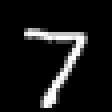

In [24]:
t1 = reshape(tX[:,1],28,28)
colorview(Gray, t1)

In [25]:
onefigure = X[:,2]
m(onefigure)

10-element Array{Float32,1}:
 0.99900216
 2.659815f-7
 0.00011560897
 9.670487f-5
 3.789181f-7
 0.0006195735
 2.803632f-5
 1.9329193f-5
 9.016732f-5
 2.7874226f-5

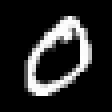

In [27]:
t1 = reshape(X[:,2],28,28)
colorview(Gray, t1)

In [28]:
opt

ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}(Float32[0.371211 -0.36470917 … -0.01857748 0.403757; -0.30993247 0.35369977 … 0.2865198 -0.308877; … ; -0.21404907 -0.018822232 … -0.11445768 -0.099103086; 0.20205645 0.35386106 … 0.031816255 0.010945133] => (Float32[-0.002340452 0.0008147057 … 0.0005721405 -0.0040540993; 0.00042545822 -0.0012857672 … -0.0040810537 0.0028622968; … ; 4.461394f-5 -0.00024326927 … 0.003881447 -0.0007869803; 0.00070955785 -0.002369356 … -0.0014933391 9.175124f-5], Float32[7.550027f-5 1.1596413f-6 … 3.388898f-7 0.00011129386; 1.8575727f-5 1.048251f-6 … 4.1585376f-6 2.7929778f-5; … ; 1.7835823f-6 3.974151f-8 … 6.3780276f-6 1.1115386f-6; 4.844259f-6 1.2800392f-6 … 6.800144f-7 2.9964285f-6], (6.349571197789829e-10, 0.8178301806491574)),Float32[0.05304868, 0.04068923, -0.03393045, -0.071381986, 0.048796844, 0.073015325, -0.0016282666, 0.057589967, -0.12515531, -0.011664683] => (Float32[-0.00030099784, -0.00078369817, -0.00040250417, 0.0013699015, -0.0007289902, -0.00190

In [29]:
?ADAM

search: ADAM ADAMW AdaMax RADAM NADAM HasDimNames AdaptiveMaxPool



```
ADAM(η = 0.001, β::Tuple = (0.9, 0.999))
```

[ADAM](https://arxiv.org/abs/1412.6980) optimiser.

# Parameters

  * Learning rate (`η`): Amount by which gradients are discounted before updating                      the weights.
  * Decay of momentums (`β::Tuple`): Exponential decay for the first (β1) and the                                  second (β2) momentum estimate.

# Examples

```julia
opt = ADAM()

opt = ADAM(0.001, (0.9, 0.8))
```
